In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm

import pandas as pd

import time
t1 = time.time()

import os
import math
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile

from datetime import datetime
from datetime import date
from datetime import timedelta

from matplotlib import cm
from pylab import rcParams
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import scipy.interpolate as spi
from scipy.interpolate import splrep, splev
import scipy.cluster.hierarchy as spc

import scipy.io
import math

from sklearn import metrics

In [3]:
#loading the files
file_dir = os.path.join('/Users/digisha/Downloads/Fatigue_project')
file_name = os.path.join(file_dir, 'All_patients_VAS_and_Sleep_diary_data_100819.xlsx')
df = pd.read_excel(file_name, sheetname = "Sheet1")

#df = pd.read_excel(file_with_data, sheetname=sheet_with_data)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [4]:
#changing datatypes - convering timestamp string to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
#drop not required coloumn
df = df.drop(['guid', 'other', 'is_checked'], axis=1)

#only depression fatigue questionnare considererd - dropping th experiment patient
df = df.loc[df['subject_id'] != 99998].reset_index(drop=True)
df.head()

with tqdm(total= len(df)) as pbar:
    for i in range(0,len(df)):
        if df['subject_id'][i] == 610:
            df['subject_id'][i] = 61
        elif df['subject_id'][i] == 600:
            df['subject_id'][i] = 60
        elif df['subject_id'][i] == 599:
            df['subject_id'][i] = 59
        pbar.update(1)
        
df.head(5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,subject_id,question_id,answer,timestamp
0,63,1600,7,2019-09-08 20:51:56
1,63,1601,3,2019-09-08 20:52:06
2,63,1602,5,2019-09-08 20:52:13
3,63,1603,1,2019-09-08 20:52:20
4,63,1600,6,2019-09-08 21:45:02


In [5]:
#df_16['time'] = df_16['time'].apply(lambda x: x.strftime('%H:%M:%S'))
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df['timestamp'].dt.dayofweek.map(dayOfWeek)

df = df[df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])].reset_index(drop=True)

In [6]:
# to check if there is a patient with less than 2 readings- as for interpolating we need atleast 2 reading 
#and will have to drop such patients
#list of patients id
UniqueNames = df.subject_id.unique()

#list of question_id
qid = df.question_id.unique()

#list of patients with less than 2 readings
l1 = []

with tqdm(total= (len(UniqueNames)*len(qid))) as pbar:
    for q in qid:
        for pat in UniqueNames:
            count = 0
            for i in range(0,len(df)):
                if q == df['question_id'][i]:
                    count += 1
            if count <= 1:
                print(pat)
                l1.append(pat)
            
            pbar.update(1)

df = df.drop(df[df.subject_id .isin(l1)].index)

In [7]:
# date column added to know if the questionnaire is a part of the same day or the next
df['date'] = [d.date() for d in df['timestamp']]

In [8]:
df.head()

,subject_id,question_id,answer,timestamp,weekday,date
0,63,1400,09-09-2019 06:22,2019-09-09 06:22:55,Monday,2019-09-09
1,63,1401,09-09-2019 06:20,2019-09-09 06:23:09,Monday,2019-09-09
2,63,1402,00:30,2019-09-09 06:23:29,Monday,2019-09-09
3,63,1403,2,2019-09-09 06:23:39,Monday,2019-09-09
4,63,1404,07:30,2019-09-09 06:24:05,Monday,2019-09-09


In [9]:
df_14 = df[['subject_id', 'timestamp','date','answer']]
df_14 = df_14.loc[df['question_id'] == 1400].reset_index(drop=True)

df_14['answer'] = pd.to_datetime(df_14['answer'])

df = df.sort_values(by=['subject_id', 'timestamp'], ascending=[1, 1]).reset_index(drop=True)

#initiating a datetime obeject as zero time for offset time
datetime_object = datetime.strptime('00:00:00', '%H:%M:%S')

In [10]:
df_14['wakeup_time'] = 0.00
df_14['prev_day_wakeup_time'] = 0.00

with tqdm(total= (len(UniqueNames)*len(df_14))) as pbar:
    for pat in UniqueNames:
        count = 0
        for i in range(0,len(df_14)):
            if pat == df_14['subject_id'][i]:
                df_14['wakeup_time'][i] = ((df_14['answer'][i] - datetime_object).seconds/(60*60))         
                if count == 0:
                    df_14['prev_day_wakeup_time'][i] = ((df_14['timestamp'][i] - datetime_object).seconds/(60*60))
                else:
                    df_14['prev_day_wakeup_time'][i] = df_14['wakeup_time'][i-1]
                count += 1
            pbar.update(1)

df_14 = df_14.drop(['timestamp', 'answer'], axis=1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
new_df = pd.merge(df, df_14,  how='left', 
                  left_on = ['subject_id','date'], 
                  right_on = ['subject_id','date'])

In [12]:
new_df = new_df[new_df['question_id'].isin([1600, 1601, 1602, 1603])].reset_index(drop=True)
new_df['wakeup_time'].fillna(6.00, inplace=True)
new_df = new_df.sort_values(by=['subject_id','timestamp','question_id'], 
                            ascending=[1, 1,1]).reset_index(drop=True)

In [13]:
new_df.head()

,subject_id,question_id,answer,timestamp,weekday,date,wakeup_time,prev_day_wakeup_time
0,1,1600,4,2018-05-31 08:45:51,Thursday,2018-05-31,11.55,20.873889
1,1,1601,0,2018-05-31 08:46:01,Thursday,2018-05-31,11.55,20.873889
2,1,1602,0,2018-05-31 08:46:09,Thursday,2018-05-31,11.55,20.873889
3,1,1603,0,2018-05-31 08:46:17,Thursday,2018-05-31,11.55,20.873889
4,1,1600,6,2018-05-31 16:16:58,Thursday,2018-05-31,11.55,20.873889


In [14]:
new_df['time'] = 0.00
new_df['flag'] = 0

qid = new_df.question_id.unique()

with tqdm(total= (len(new_df)*len(qid))) as pbar:
    for q in qid:
        for i in range(0,len(new_df)):
            if q == new_df['question_id'][i]:
                int_time = ((new_df['timestamp'][i] - datetime_object).seconds/(60*60))
                new_df['time'][i] = int_time - new_df['wakeup_time'][i]
                if math.isnan(new_df['prev_day_wakeup_time'][i]):
                    #print(i,q,pat,prev_day_wakeup_time,new_df['wakeup_time'][i])
                    new_df['prev_day_wakeup_time'][i] = prev_day_wakeup_time
                if new_df['time'][i] < 0:
                    new_df['time'][i] = new_df['prev_day_wakeup_time'][i] + 24.0 - int_time 
                    new_df['flag'][i] = 1
                prev_day_wakeup_time = new_df['wakeup_time'][i]
                #print(i,q, prev_day_wakeup_time)
            pbar.update(1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/

In [15]:
new_df.head()

,subject_id,question_id,answer,timestamp,weekday,date,wakeup_time,prev_day_wakeup_time,time,flag
0,1,1600,4,2018-05-31 08:45:51,Thursday,2018-05-31,11.55,20.873889,36.109722,1
1,1,1601,0,2018-05-31 08:46:01,Thursday,2018-05-31,11.55,20.873889,36.106944,1
2,1,1602,0,2018-05-31 08:46:09,Thursday,2018-05-31,11.55,20.873889,36.104722,1
3,1,1603,0,2018-05-31 08:46:17,Thursday,2018-05-31,11.55,20.873889,36.102500,1
4,1,1600,6,2018-05-31 16:16:58,Thursday,2018-05-31,11.55,20.873889,4.732778,0


In [16]:
df = new_df

#changing the datatype of answer column to integer
df['answer']=df.answer.astype('int64')

df['day'] = 0

#len(UniqueNames)*len(qid)
with tqdm(total= (len(UniqueNames)*len(df)*len(qid))) as pbar:
    for q in qid:
        for pat in UniqueNames:
            ref_date = date(1900, 1, 1)
            count = 0
            for i in range(0,len(df)):
                if q == df['question_id'][i]:
                    if pat == df['subject_id'][i]:
                        if count == 0:
                            df['day'][i] = 0
                            ref_date = df['date'][i]
                            
                        elif df['date'][i] != ref_date and df['flag'][i] == 1:
                            df['day'][i] = day_number
                        
                        elif df['date'][i] != ref_date and df['flag'][i] == 0:
                            df['day'][i] = day_number + 1
                            ref_date = df['date'][i]
                            
                        else:
                            df['day'][i] = day_number
                            ref_date = df['date'][i]

                        day_number = df['day'][i]
                        #print(day_number)
                        count += 1
                        
                pbar.update(1)

df = df.drop(['timestamp', 'date', 'wakeup_time', 'prev_day_wakeup_time','flag'], axis=1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to 

In [17]:
df.head()

,subject_id,question_id,answer,weekday,time,day
0,1,1600,4,Thursday,36.109722,0
1,1,1601,0,Thursday,36.106944,0
2,1,1602,0,Thursday,36.104722,0
3,1,1603,0,Thursday,36.102500,0
4,1,1600,6,Thursday,4.732778,0


In [18]:
(time.time() - t1)/60
##############

13.863757065931956

In [24]:
qid = df.question_id.unique()
def plot_24hours(ndf,pat,q):
    
    attribute = {1600:'Fatigue', 1601:'Depression', 1602:'Anxiety', 1603:'Pain'}
    plt.yticks(np.arange(0, 11, 1))
    plt.xticks(np.arange(0, 25, 1))
    plt.ylim(0, 10)
    plt.xlim(0, 25)
    plt.title('Subject : '+ str(pat) + ' & Attribute: '+ attribute[q])
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    sns.lineplot(x = 'time', y="answer", hue = "day", data = ndf, markers = '^',
                 palette=sns.color_palette('Dark2', n_colors = (ndf['day'].max()+1)))
    
    plt.legend(loc='upper right')
    plt.xlabel('Time (hours)') 

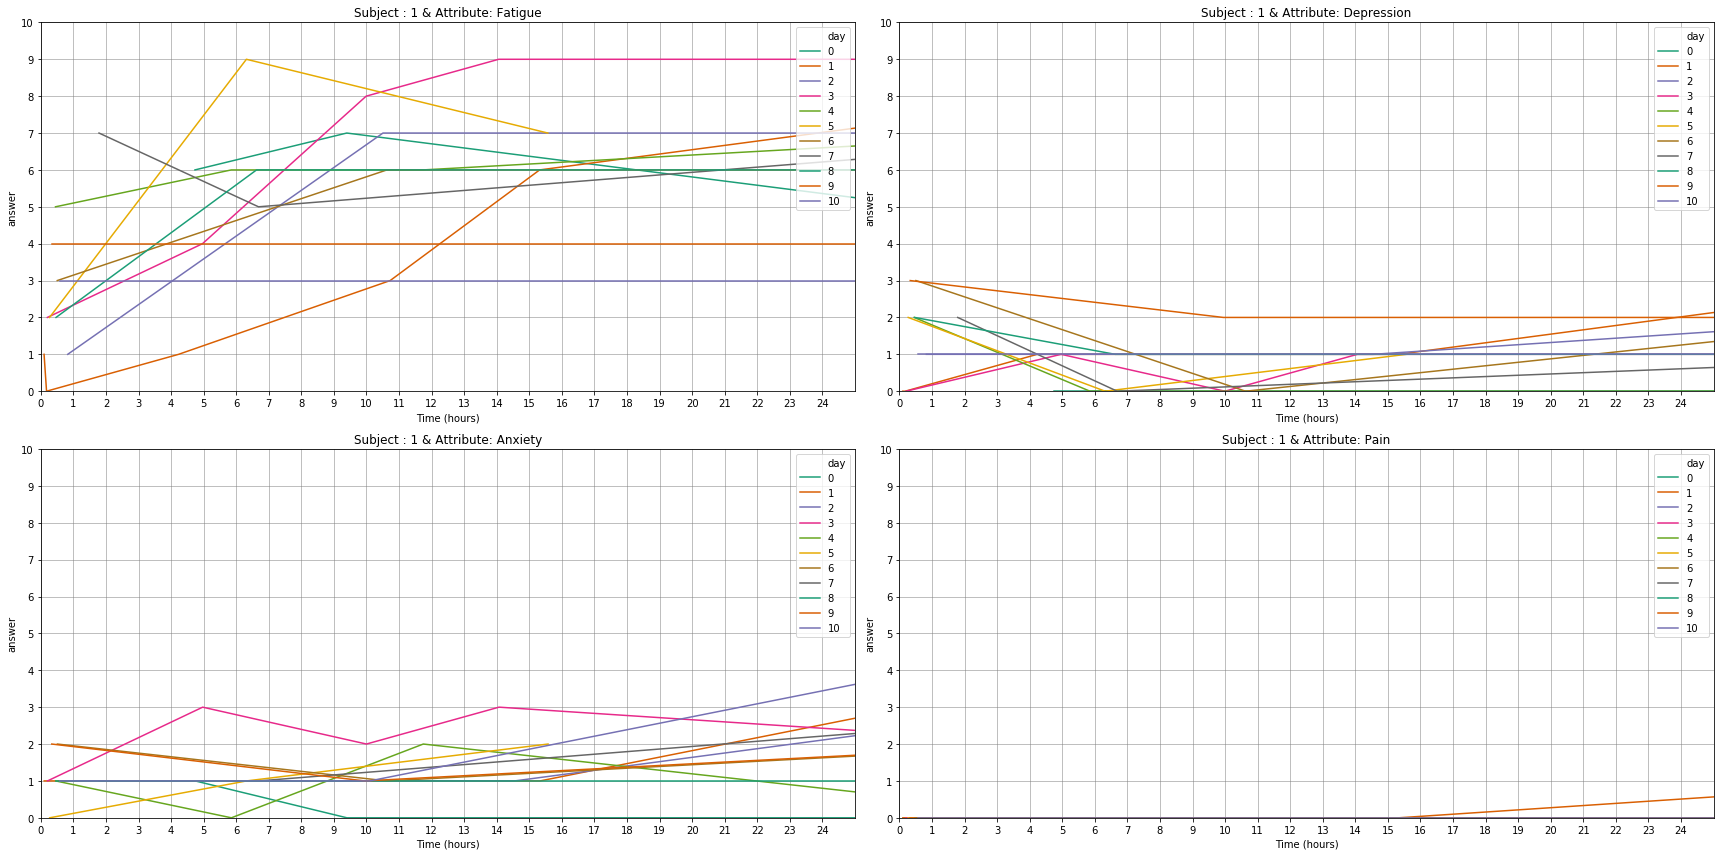

In [25]:
df = df.sort_values(by=['subject_id', 'question_id','day'], ascending=[1, 1,1]).reset_index(drop=True)
#UniqueNames
with tqdm(total= (len(UniqueNames))) as pbar:
    for pat in [1]:
        i = 0
        plt.figure(figsize = (24,12))
        for q in qid:
            i = i+1
            plt.subplot(2, 2, i)
            ndf = df[(df.question_id == q) & (df.subject_id == pat)]
            plot_24hours(ndf,pat,q)
        plt.tight_layout()
        plt.savefig('Subject '+ str(pat)+".png")
        pbar.update(1)

In [21]:
(time.time() - t1)/60
##############

13.894548896948496